In [3]:
# Install pyspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=53e34b777b25c526fdadb186e1ff15616327b240c728e5ebd627428852d6f781
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [5]:
from google.colab import files
uploaded = files.upload()

Saving realdata.csv to realdata.csv


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Creation of Sparkecion
spark = SparkSession.builder.appName("CSV Processing").getOrCreate()

# Read the CSV file as a DataFrame
data = spark.read.csv("./realdata.csv", header=True, inferSchema=True)

# Move the "views" column to the last column
data = data.select([col for col in data.columns if col != 'views'] + ['views'])

# Map the values of the application_type column
data = data.withColumn("application_type", when(col("application_type") == "ComplexOnsiteApply", 3)
                       .when(col("application_type") == "OffsiteApply", 1)
                       .when(col("application_type") == "SimpleOnsiteApply", 2)
                       .otherwise(col("application_type")))

In [10]:
data = data.withColumn("formatted_experience_level", when(col("formatted_experience_level") == "Associate", 6)
                       .when(col("formatted_experience_level") == "Director", 7)
                       .when(col("formatted_experience_level") == "Entry level", 2)
                       .when(col("formatted_experience_level") == "Executive", 5)
                       .when(col("formatted_experience_level") == "Internship", 3)
                       .when(col("formatted_experience_level") == "Mid-Senior level", 4)
                       .when(col("formatted_experience_level") == "Not_Specified", 1)
                       .otherwise(col("formatted_experience_level")))
data.toPandas()

med_salary application_type formatted_experience_level  sponsored  \
0       5250.000000                1                          2          0   
1       5250.000000                1                          2          0   
2      16257.100000                1                          2          0   
3      14089.000000                1                          2          0   
4      14089.000000                1                          2          0   
...             ...              ...                        ...        ...   
12404   8688.387500                1                          4          0   
12405  13140.000000                2                          1          0   
12406  12000.000000                1                          1          0   
12407  10220.000000                3                          1          0   
12408   3291.666667                3                          1          1   

       company_size      PCA1  views  
0               5.0 -0.000011    9.0  
1               5.0 -0.000011    2.0  
2               4.0  0.000009    1.0  
3               4.0  0.000009    0.0  
4               4.0  0.000009    0.0  
...             ...       ...    ...  
12404           3.0 -0.000013    0.0  
12405           1.0 -0.000017    0.0  
12406           2.0 -0.000022    0.0  
12407           2.0  0.000015    2.0  
12408           2.0 -0.000024   49.0  

[12409 rows x 7 columns]

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev, col
import pandas as pd

df = data

# The mean and standard deviation are calculated
mean_val = df.select(mean(col('views'))).collect()[0][0]
stddev_val = df.select(stddev(col('views'))).collect()[0][0]

# Define the z-score normalization function
def z_score_normalize(value):
    return (value - mean_val) / stddev_val

# Register a UDF
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
z_score_udf = udf(z_score_normalize, DoubleType())

# Add a new column and replace the original one
df = df.withColumn('views_normalized', z_score_udf(col('views')))
df = df.drop('views').withColumnRenamed('views_normalized', 'views')
print(df)
d1 = df.toPandas()
print(d1)
# Save the results
d1.to_csv('./normalized_realdata2.csv', header=True)


DataFrame[med_salary: double, application_type: string, formatted_experience_level: string, sponsored: int, company_size: double, PCA1: double, views: double]
         med_salary application_type formatted_experience_level  sponsored  \
0       5250.000000                1                          2          0   
1       5250.000000                1                          2          0   
2      16257.100000                1                          2          0   
3      14089.000000                1                          2          0   
4      14089.000000                1                          2          0   
...             ...              ...                        ...        ...   
12404   8688.387500                1                          4          0   
12405  13140.000000                2                          1          0   
12406  12000.000000                1                          1          0   
12407  10220.000000                3                         

In [12]:

df = spark.read.csv('./normalized_realdata2.csv', inferSchema=True, header=True)

# The mean and standard deviation are calculated
mean_val = df.select(mean(col('med_salary'))).collect()[0][0]
stddev_val = df.select(stddev(col('med_salary'))).collect()[0][0]

# Define the z-score normalization function
def z_score_normalize(value):
    return (value - mean_val) / stddev_val

# Register a UDF
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
z_score_udf = udf(z_score_normalize, DoubleType())

# Add a new column and replace the original one
df = df.withColumn('med_salary_normalized', z_score_udf(col('med_salary')))
df = df.drop('med_salary').withColumnRenamed('med_salary_normalized', 'med_salary')
print(df)
d1 = df.toPandas()
print(d1)
# Save the results
d1.to_csv('normalized_realdata2.csv', header=True)

# Stop the Spark session
spark.stop()


DataFrame[_c0: int, application_type: int, formatted_experience_level: int, sponsored: int, company_size: double, PCA1: double, views: double, med_salary: double]
         _c0  application_type  formatted_experience_level  sponsored  \
0          0                 1                           2          0   
1          1                 1                           2          0   
2          2                 1                           2          0   
3          3                 1                           2          0   
4          4                 1                           2          0   
...      ...               ...                         ...        ...   
12404  12404                 1                           4          0   
12405  12405                 2                           1          0   
12406  12406                 1                           1          0   
12407  12407                 3                           1          0   
12408  12408                 3    

In [13]:
import pandas as pd

# Read the file without using the first row as the column name
data = pd.read_csv("normalized_realdata2.csv")

# Delete the first and second columns
data = data.iloc[:, 2:]

# Move the last column to the first column
last_column = data.iloc[:, -1]  # 获取最后一列
data = pd.concat([last_column, data.iloc[:, :-1]], axis=1)  # 将最后一列与其他列拼接

# Save the modified data
data.to_csv("modified_normalized_realdata2.csv", index=False)

1


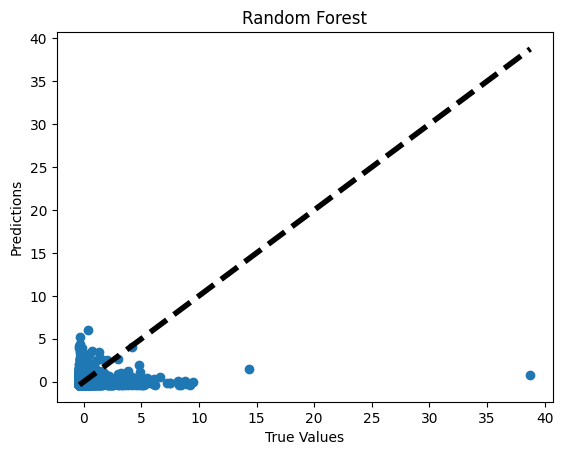

mae: 0.4350980775830524
mse: 1.0592724221799277


In [14]:
# -*- coding: utf-8 -*-

from sklearn import tree
import graphviz
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
mae_list, mse_list, mape_list = [], [], []
pred=[]
reg = []
for i in range(100):
    data = pd.read_csv(("modified_normalized_realdata2.csv"))
    X = data.iloc[:,:6].values
    y = data.iloc[:,6].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)


    r1 = RandomForestRegressor().fit(X_train, y_train)
    reg.append(r1)
    p1=r1.predict(X_test)
    pred.append(r1.predict(X_test))

    mae = mean_absolute_error(y_test, p1)
    mse = mean_squared_error(y_test, p1)
    mape = mean_absolute_percentage_error(y_test, p1)
    # print(reg.get_metadata_routing())
    mae_list.append(mae)
    mse_list.append(mse)
    mape_list.append(mape)
c = mse_list.index(min(mse_list))
print(c)
estimator = reg[c].estimators_[0]
dot_data = tree.export_graphviz(estimator, out_file=None, feature_names=data.columns[:6], filled=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree",directory="./")
# Plot the prediction results of the random forest model compared to the true value and the adjusted comparison chart
plt.scatter(y_test, pred[c])
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Random Forest')
plt.show()



print(f"mae: {np.mean(mae_list)}")
print(f"mse: {np.mean(mse_list)}")

